# Background Modeling

When fitting a spectrum with a background, it is invalid to simply subtract off the background if the background is part of the data's generative model. Therefore, we are often left with the task of modeling the statistical process of the background along with our source. 

In typical spectral modeling, we find a few common cases when background is involved. If we have total counts ($S_i$) in $i^{\rm th}$ on $N$ bins observed for an exposure of $t_{\rm s}$ and also a measurement of $B_i$ background counts from looking off source for $t_{\rm b}$ seconds, we can then suppose a model for the source rate ($m_i$) and background rate ($b_i$).

**Poisson source with Poisson background**

This is described by a likelihood of the following form:

$$ L = \prod^N_{i=1} \frac{(t_{\rm s}(m_i+b_i))^{S_i} e^{-t_{\rm s}(m_i+b_i)}}{S_i!} \times \frac{(t_{\rm b} b_i)^{B_i} e^{-t_{\rm b}b_i}}{B_i!}  $$

which is a Poisson likelihood for the total model ($m_i +b_i$) conditional on the Poisson background observation. This is the typical case for e.g. apeture x-ray instruments that observe a source region and then a background region. Both observations are Poisson distributed.

**Poisson source with Gaussian background**

This likelihood is similar, but the conditonal background distribution is described by Gaussian:

$$ L = \prod^N_{i=1} \frac{(t_{\rm s}(m_i+b_i))^{S_i} e^{-t_{\rm s}(m_i+b_i)}}{S_i!} \times \frac{1}{\sigma_{b,i}\sqrt{2 \pi}} \exp \left[ \frac{({B_i} - t_{\rm b} b_i)^2} {2 \sigma_{b,i}^2} \right] $$

where the $\sigma_{b,i}$ are the measured errors on $B_i$. This situation occurs e.g. when the background counts are estimated from a fitted model.

In 3ML, we can fit a background model along with the the source model which allows for arbitrarily low background counts (in fact zero) in channels. The alternative is to use profile likelihoods where we first differentiate the likelihood with respect to the background model

$$ \frac{ \partial L}{{\partial b_i}} = 0$$

and solve for the $b_i$ that maximize the likelihood. Both the Poisson and Gaussian background profile likelihoods are described in the [XSPEC statistics guide](https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/XSappendixStatistics.html). This implicitly yields $N$ parameters to the model thus requiring at least one background count per channel. These likelihoods are the default in 3ML when a background model is not used with a SpectrumLike plugin.

Let's examine how to hanlde both cases.


In [18]:
from threeML import *

%matplotlib inline

import warnings

warnings.simplefilter('ignore')

First we will simulate an observation where we have a simulated broken power law source spectrum along with an observed background spectrum that is a continuum background with a Gaussian line.

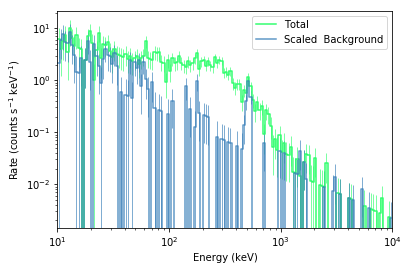

In [22]:

# create the simulated observation

energies = np.logspace(1,4,151)

low_edge = energies[:-1]
high_edge = energies[1:]

# get a BPL source function
source_function = Broken_powerlaw(K=2,xb=300,piv=300, alpha=0., beta=-3.)

# power law background function
background_function = Powerlaw(K=.5,index=-1.5, piv=100.) + Gaussian(F=50,mu=511,sigma=20)

spectrum_generator = SpectrumLike.from_function('fake',
                                               source_function=source_function,
                                               background_function=background_function,
                                               energy_min=low_edge,
                                               energy_max=high_edge)


spectrum_generator.view_count_spectrum()

## Using a profile likelihood

We have very few counts counts in some channels (in fact sometimes zero), but let's assume we do not know the model for the background. In this case, we will use the profile Poisson likelihood.

Best fit values:



,result,unit
parameter,,
source.spectrum.main.Broken_powerlaw.K,2.190 +/- 0.16,1 / (cm2 keV s)
source.spectrum.main.Broken_powerlaw.xb,(2.860 +/- 0.11) x 10^2,keV
source.spectrum.main.Broken_powerlaw.alpha,(4.000 +/- 8) x 10^-2,
source.spectrum.main.Broken_powerlaw.beta,-2.880 +/- 0.13,



Correlation matrix:



1.00,-0.64,0.78,0.02
-0.64,1.00,-0.49,-0.57
0.78,-0.49,1.00,0.01
0.02,-0.57,0.01,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
fake,402.309993
total,402.309993



Values of statistical measures:



,statistical measures
AIC,812.895848
BIC,824.662527


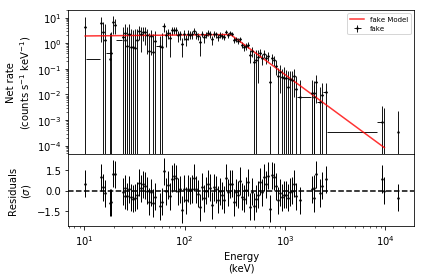

In [23]:
bpl = Broken_powerlaw(piv=300,xb=500)

ps_src = PointSource('source',0,0,spectral_shape=bpl)

src_model = Model(ps_src)

jl_profile = JointLikelihood(src_model,DataList(spectrum_generator))

jl_profile.set_minimizer('ROOT')

_ = jl_profile.fit()

_ = spectrum_generator.display_model(step=False) 

Our fit recovers the simulated parameters. However, we should have binned the spectrum up such that there is at least one background count per spectral bin for the profile to be valid.

Best fit values:



,result,unit
parameter,,
source.spectrum.main.Broken_powerlaw.K,2.200 +/- 0.13,1 / (cm2 keV s)
source.spectrum.main.Broken_powerlaw.xb,(2.820 +/- 0.04) x 10^2,keV
source.spectrum.main.Broken_powerlaw.alpha,(6.000 +/- 7) x 10^-2,
source.spectrum.main.Broken_powerlaw.beta,-2.810 +/- 0.11,



Correlation matrix:



1.00,-0.27,0.71,-0.46
-0.27,1.00,-0.18,-0.23
0.71,-0.18,1.00,-0.30
-0.46,-0.23,-0.30,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
fake,288.063976
total,288.063976



Values of statistical measures:



,statistical measures
AIC,584.403813
BIC,596.170493


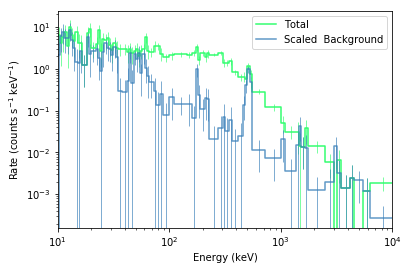

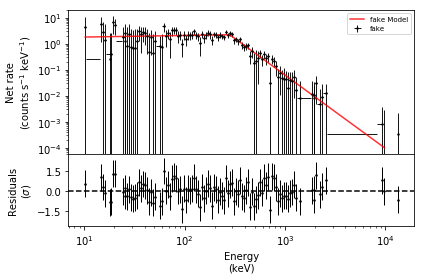

In [24]:
spectrum_generator.rebin_on_background(1)

spectrum_generator.view_count_spectrum()

_ = jl_profile.fit()

_ = spectrum_generator.display_model(step=False) 

## Modeling the background

Now let's try to model the background assuming we know that the background is a power law with a Gaussian line. We can extract a background plugin from the data by passing the original plugin to a classmethod of spectrum like.

In [26]:
background_plugin = SpectrumLike.from_background('bkg',spectrum_generator)

Auto-probed noise models:
- observation: poisson
- background: None


This constructs a new plugin with only the observed background so that we have first model it.

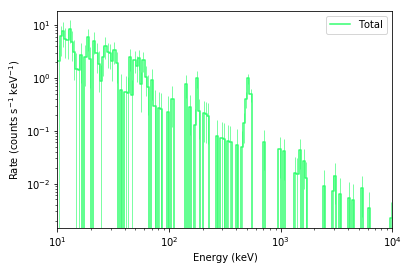

In [27]:
background_plugin.view_count_spectrum()

We now construct our background model and fit it to the data. Let's assume we know that the line occurs at 511 keV, but we are unsure of its strength an width. We do not need to bin the data up because we are using a simple Poisson likelihood which is valid even when we have zero counts.

Best fit values:



,result,unit
parameter,,
bkg.spectrum.main.composite.K_1,(3.07 -0.23 +0.24) x 10^-1,1 / (cm2 keV s)
bkg.spectrum.main.composite.index_1,-1.390 +/- 0.04,
bkg.spectrum.main.composite.F_2,(4.400 +/- 0.7) x 10,1 / (cm2 s)
bkg.spectrum.main.composite.sigma_2,(1.740 +/- 0.25) x 10,keV



Correlation matrix:



1.00,0.17,-0.04,-0.05
0.17,1.00,-0.04,-0.04
-0.04,-0.04,1.00,0.08
-0.05,-0.04,0.08,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
bkg,213.580385
total,213.580385



Values of statistical measures:



,statistical measures
AIC,435.436631
BIC,447.203310


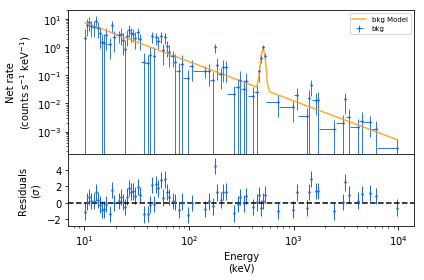

In [29]:
bkg_spectrum = Powerlaw(piv=100) +  Gaussian(F=50,mu=511)

bkg_spectrum.mu_2.fix = True
bkg_spectrum.K_1.bounds = (1E-4, 10)
bkg_spectrum.F_2.bounds = (0., 1000)
bkg_spectrum.sigma_2.bounds = (2,30)

ps_bkg = PointSource('bkg',0,0,spectral_shape=bkg_spectrum)

bkg_model = Model(ps_bkg)


jl_bkg = JointLikelihood(bkg_model,DataList(background_plugin))

jl_bkg.set_minimizer('ROOT')

_ = jl_bkg.fit()

_ = background_plugin.display_model(step=False, data_color='#1A68F0', model_color='#FF9700')

We now have a model and estimate for the background which we can use when fitting with the source spectrum. We now create a new plugin with just the total observation and pass our background plugin as the background argument.

In [30]:
modeled_background_plugin = SpectrumLike('full',
                                         # here we use the original observation
                                         observation=spectrum_generator.observed_spectrum,
                                         background=background_plugin)

Background modeled from plugin: bkg
Auto-probed noise models:
- observation: poisson
- background: poisson


When we look at out count spectrum now, we will see the *predicted* background, rather than the measured one:

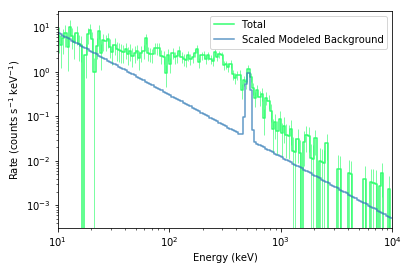

In [31]:
modeled_background_plugin.view_count_spectrum()

Now we simply fit the spectrum as we did in the profiled case. The background plugin's parameters are stored in our new plugin as nuissance parameters:

In [32]:
modeled_background_plugin.nuisance_parameters

OrderedDict([('cons_full', Parameter cons_full = 1.0 []
              (min_value = 0.8, max_value = 1.2, delta = 0.05, free = False)),
             ('bkg_bkg_position_ra_full', Parameter ra = 0.0 [deg]
              (min_value = 0.0, max_value = 360.0, delta = 0.1, free = False)),
             ('bkg_bkg_position_dec_full', Parameter dec = 0.0 [deg]
              (min_value = -90.0, max_value = 90.0, delta = 0.1, free = False)),
             ('bkg_bkg_spectrum_main_composite_K_1_full',
              Parameter K_1 = 0.306988996628 [1 / (cm2 keV s)]
              (min_value = 0.0001, max_value = 10.0, delta = 0.1, free = True)),
             ('bkg_bkg_spectrum_main_composite_piv_1_full',
              Parameter piv_1 = 100.0 [keV]
              (min_value = None, max_value = None, delta = 0.1, free = False)),
             ('bkg_bkg_spectrum_main_composite_index_1_full',
              Parameter index_1 = -1.39330438822 []
              (min_value = -10.0, max_value = 10.0, delta = 0.2, fre

and the fitting engine will use them in the fit. The parameters will still be connected to the background plugin and its model and thus we can free/fix them there as well as set priors on them.

In [33]:
bpl = Broken_powerlaw(piv=300,xb=500)

bpl.K.bounds = (1E-5,1E1)
bpl.xb.bounds = (1E1,1E4)



ps_src = PointSource('source',0,0,bpl)

src_model = Model(ps_src)


jl_src = JointLikelihood(src_model,DataList(modeled_background_plugin))

In [34]:


jl_src.set_minimizer("ROOT")

In [35]:
_ = jl_src.fit()

Best fit values:



,result,unit
parameter,,
source.spectrum.main.Broken_powerlaw.K,2.090 +/- 0.12,1 / (cm2 keV s)
source.spectrum.main.Broken_powerlaw.xb,(2.884 +/- 0.013) x 10^2,keV
source.spectrum.main.Broken_powerlaw.alpha,(-6.000 +/- 10) x 10^-2,
source.spectrum.main.Broken_powerlaw.beta,-2.890 +/- 0.14,
K_1,(2.500 +/- 1.3) x 10^-1,1 / (cm2 keV s)
index_1,-1.280 +/- 0.08,
F_2,(3.200 +/- 1.0) x 10,1 / (cm2 s)
sigma_2,(1.800 +/- 0.8) x 10,keV



Correlation matrix:



1.00,-0.09,0.67,-0.49,0.35,-0.20,-0.10,-0.08
-0.09,1.00,-0.06,-0.06,-0.02,0.04,-0.01,-0.01
0.67,-0.06,1.00,-0.50,0.79,-0.42,-0.04,-0.03
-0.49,-0.06,-0.50,1.00,-0.55,-0.20,-0.21,-0.17
0.35,-0.02,0.79,-0.55,1.00,-0.24,0.04,0.03
-0.20,0.04,-0.42,-0.20,-0.24,1.00,0.11,0.09
-0.10,-0.01,-0.04,-0.21,0.04,0.11,1.00,0.54
-0.08,-0.01,-0.03,-0.17,0.03,0.09,0.54,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
full,294.571515
total,294.571515



Values of statistical measures:



,statistical measures
AIC,606.164306
BIC,629.228112


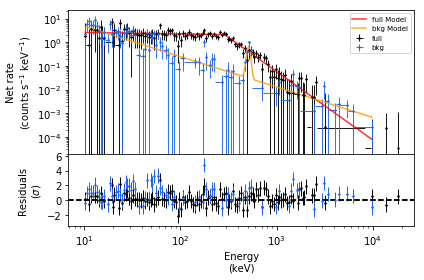

In [36]:
fig = modeled_background_plugin.display_model(step=False)

_ = background_plugin.display_model(data_color='#1A68F0', model_color='#FF9700',model_subplot=fig.axes,step=False)